In [1]:
import numpy as np
import pandas as pd

In [2]:
import sqlite3

#read the CSV
owners = pd.read_csv('owners.csv')
pets = pd.read_csv('pets.csv')
procedures = pd.read_csv('procedures.csv')
procedure_details = pd.read_csv('procedure_details.csv')

#create/connect to a database
conn = sqlite3.connect("DenverBroncos.db")

#store tables in the database:
owners.to_sql('owners', conn, if_exists='replace')
pets.to_sql('pets', conn, if_exists='replace')
procedures.to_sql('procedures', conn, if_exists='replace')
procedure_details.to_sql('procedure_details', conn, if_exists='replace')

In [3]:
#Which pet (enter pet's name) had the most procedures?
query1 = 'SELECT Name AS [Pet\'s name: ] FROM pets AS pe\
            JOIN procedures AS pr ON pe.PetID = pr.PetID\
            GROUP BY pr.PetID\
            ORDER BY COUNT(*)\
            DESC\
            LIMIT 1;'

result1 = pd.read_sql(query1, conn).to_string(index=False)
print(result1)

Pet's name: 
  Bonaparte


In [4]:
#Which owner (enter OwnerID) spent the most on a procedure or procedures for his/her pet(s)?
query2 = 'SELECT o.Name AS [Owner\'s name: ] FROM owners AS o\
            JOIN pets AS pe ON o.OwnerID = pe.OwnerID\
            JOIN procedures AS pr ON pe.PetID = pr.PetID\
            JOIN procedure_details AS pd ON pr.ProcedureSubCode = pd.ProcedureSubCode\
            AND pr.ProcedureType = pd.ProcedureType\
            GROUP BY pr.PetID\
            ORDER BY SUM(Price)\
            DESC\
            LIMIT 1;'

result2 = pd.read_sql(query2, conn).to_string(index=False)
print(result2)

Owner's name: 
       Daniel


In [5]:
#What is the mean price per procedure for pets with owners who have a 49503 zip code?
query3 = 'SELECT ROUND(AVG(CAST(Price AS FLOAT)),2) AS [Mean price: ] FROM procedure_details AS pd\
            JOIN procedures AS pr ON pd.ProcedureSubCode = pr.ProcedureSubCode\
            AND pr.ProcedureType = pd.ProcedureType\
            JOIN pets AS pe ON pr.PetID = pe.PetID\
            JOIN owners AS o on pe.OwnerID = o.OwnerID\
            WHERE o.ZipCode = 49503;'

result3 = pd.read_sql(query3, conn).to_string(index=False)
print(result3)

Mean price: 
       155.0


In [6]:
#What percentage of dogs in pets.csv that have a "c" in their name are male? 
query4 = 'SELECT ROUND(CAST((COUNT(Name)*100) AS FLOAT)/CAST((SELECT COUNT(*) FROM pets WHERE Name LIKE \'%c%\') AS FLOAT),2) AS [Percentage:] FROM pets\
            WHERE Gender = \'male\' AND Name LIKE \'%c%\';'

result4 = pd.read_sql(query4, conn).to_string(index=False)
print(result4,'%')

Percentage:
      48.65 %


In [7]:
#What is the standard deviation of age for dogs?
query50 = 'SELECT (Age-(SELECT AVG(Age) FROM pets))*(Age-(SELECT AVG(Age) FROM pets)) AS [x]\
            FROM pets\
            WHERE Kind = \'Dog\'\
            GROUP BY PetID;'
query51 = 'SELECT COUNT(*) AS y FROM pets'

r50 = pd.read_sql(query50, conn)
r51 = pd.read_sql(query51, conn)
result5 = np.around(np.sqrt(r50.x.sum()/r51.y), decimals=2).to_string(index=False)
print('STDV of age for dogs: ', result5)

STDV of age for dogs:  3.21


In [8]:
#How old is the oldest parrot?
query6 = 'SELECT Age AS [Oldest parrot\'s age: ] FROM pets\
            WHERE Kind = \'Parrot\'\
            ORDER BY Age\
            DESC\
            LIMIT 1;'

result6 = pd.read_sql(query6, conn).to_string(index=False)
print(result6)

Oldest parrot's age: 
                   11


In [9]:
#What is the mean age of cats? Keep answer in decimal format and round to the nearest hundredth (e.g. 0.75)
query7 = 'SELECT ROUND(AVG(CAST(Age AS FLOAT)),2) AS [Mean cats age: ] FROM pets\
            WHERE Kind = \'Cat\'\
            GROUP BY Kind;'

result7 = pd.read_sql(query7, conn).to_string(index=False)
print(result7)

Mean cats age: 
           7.32


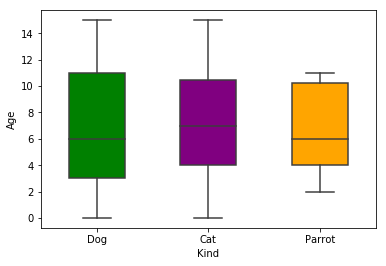

In [10]:
#Please upload an image of a box plot with kind of pet on the x-axis and pet age on the y-axis. 
#The distributions of dog, cat and parrot ages should be shown in green, purple and orange, respectively. 
#An example of a box plot can be found here: https://ggplot2.tidyverse.org/reference/geom_boxplot.html 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

kind = list(set(pets.Kind))
pet_colors = ['green','purple','orange']
color_dict = dict(zip(kind, pet_colors))

bplot = sns.boxplot(y = 'Age', x = 'Kind', data = pets, width = 0.5)
                  
for i in range(0, len(kind)):
    mybox = bplot.artists[i]
    mybox.set_facecolor(color_dict[kind[i]])

bplot

In [11]:
#BONUS: Please upload a script with a user-defined function that accepts OwnerID as an input and returns 
#a vector of pet names for the given OwnerID.

def func(ownerID):
    return 'SELECT Name FROM pets WHERE OwnerID = {}'.format(ownerID)

#run it as a simple SQL query
print(pd.read_sql(func(8133), conn).to_string(index=False))

Name
    Taz
  Candy
Humbert


In [12]:
#create a function and execute it
conn.create_function('script', 1, func)
try:
    #print((conn.execute('SELECT f(?)', (8133,)).fetchall()))
    cur = conn.cursor()
    cur.execute('SELECT script(?)', (8133,))
    print(cur.fetchone()[0])
except sqlite3.Error as error:
    print(error)

SELECT Name FROM pets WHERE OwnerID = 8133


In [13]:
#OR with python(using pandas dataframe)
def script(ownerID):
    return list(pets.Name.loc[pets['OwnerID'] == ownerID])

#script(8133)

['Taz', 'Candy', 'Humbert']

In [14]:
#user-defined fuction (not supported in sqlite)
'''CREATE FUNCTION dbo.GetPetsName(@OwnderID int)
    RETURNS TABLE
    AS 
    BEGIN
        RETURN
        SELECT Name FROM pets WHERE ownerdID = @ownerdID
    END;'''

'CREATE FUNCTION dbo.GetPetsName(@OwnderID int)\n    RETURNS TABLE\n    AS \n    BEGIN\n        RETURN\n        SELECT Name FROM pets WHERE ownerdID = @ownerdID\n    END;'